## Data source: 
https://github.com/LieberInstitute/spatialLIBD

In [2]:
'asdmyatextasdf'.index('mytext')

ValueError: substring not found

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
from scipy import sparse
from pathlib import Path
import scanpy as sc
# import rnanorm

In [4]:
col_metadata = pd.read_csv(r'../data/column_metadata.csv', index_col=0)
row_metadata = pd.read_csv(r'../data/row_metadata.csv', index_col=0)
# row_metadata
# col_metadata

In [5]:
with h5py.File(r'../data/151507_raw_feature_bc_matrix.h5', "r") as f:
    f.visit(print)
    matrix = pd.DataFrame(np.array(f['matrix']))
    barcodes = pd.DataFrame(np.array(f['matrix']['barcodes']))
    data = (np.array(f['matrix']['data']))
    _all_tag_keys = pd.DataFrame(np.array(f['matrix']['features']['_all_tag_keys']))
    feature_type = pd.DataFrame(np.array(f['matrix']['features']['feature_type']))
    genome = pd.DataFrame(np.array(f['matrix']['features']['genome']))
    _id = pd.DataFrame(np.array(f['matrix']['features']['id']))
    name = pd.DataFrame(np.array(f['matrix']['features']['name']))
    indices = pd.DataFrame(np.array(f['matrix']['indices']))
    indptr = pd.DataFrame(np.array(f['matrix']['indptr']))
    shape = (np.array(f['matrix']['shape']))
    print('')
    print(f['matrix']['features'].keys())
    print(f['matrix']['features']['genome'])
    print(f['matrix']['features']['_all_tag_keys'])
    print(f['matrix']['features']['feature_type'])
    print(f['matrix']['features']['id'])
    print(f['matrix']['features']['name'])

matrix
matrix/barcodes
matrix/data
matrix/features
matrix/features/_all_tag_keys
matrix/features/feature_type
matrix/features/genome
matrix/features/id
matrix/features/name
matrix/indices
matrix/indptr
matrix/shape

<KeysViewHDF5 ['_all_tag_keys', 'feature_type', 'genome', 'id', 'name']>
<HDF5 dataset "genome": shape (33538,), type "|S6">
<HDF5 dataset "_all_tag_keys": shape (1,), type "|S6">
<HDF5 dataset "feature_type": shape (33538,), type "|S15">
<HDF5 dataset "id": shape (33538,), type "|S15">
<HDF5 dataset "name": shape (33538,), type "|S16">


In [6]:
def load_sparse_mat(raw_filename, filtered_filename, sample_number):
    with h5py.File(raw_filename, 'r') as f:
        raw_barcodes = np.array(f['matrix']['barcodes']).astype('U13')
#         _id = np.array(f['matrix']['features']['id']).astype('U13')   #  b'ENSG00000275063' 33538 rows
#         name = np.array(f['matrix']['features']['name']).astype('U13')   # Gene name b'AL627309.3' 33538 rows
        
    with h5py.File(filtered_filename, 'r') as f:
        data = np.array(f['matrix']['data'])
        filtered_barcodes = np.array(f['matrix']['barcodes']).astype('U13')  # b'AAACAAGTATCTCCCA-1'  4992 columns
        _id = np.array(f['matrix']['features']['id']).astype('U13')   #  b'ENSG00000275063' 33538 rows
        name = np.array(f['matrix']['features']['name']).astype('U13')   # Gene name b'AL627309.3' 33538 rows
        indices = np.array(f['matrix']['indices'])
        indptr = np.array(f['matrix']['indptr'])
        shape = np.array(f['matrix']['shape'])
        
    barcodes = pd.DataFrame(filtered_barcodes)
    barcodes['in_filtered'] = barcodes[0].isin(filtered_barcodes).astype('int')
#     print(barcodes.shape)
    m = sparse.csr_matrix((data, indices, indptr), shape=(shape[1], shape[0]))
    index = [barcodes[0].astype('str').to_list(), 
#              barcodes['in_filtered'].astype('str').to_list(), 
             [str(sample_number)]*len(barcodes)]
    columns = [name, _id]
#     print(len(index[0]))
#     print(len(columns[0]))
#     m = pd.DataFrame(m.toarray(), index=index, columns=columns).T
    return m.toarray()
#     return m

In [7]:
rawfiles = Path(r'..\data').glob(pattern='*raw*.h5')
filtfiles = Path(r'..\data').glob('*filt*.h5')
print(filtfiles)

<generator object Path.glob at 0x000002B82173D448>


In [8]:
dfs = []
rawfiles = Path(r'..\data').glob(pattern='*raw*.h5')
filtfiles = Path(r'..\data').glob('*filt*.h5')

for raw_file, filtered_file in zip(rawfiles, filtfiles):
    sample_number = raw_file.stem.split('_')[0]
    df = load_sparse_mat(raw_filename=raw_file, filtered_filename=filtered_file, sample_number=sample_number)
    dfs.append(df)
    
cdf = np.concatenate(dfs)
cdf.shape
adata = sc.AnnData(X=cdf, obs=col_metadata, var=row_metadata)  # obs = rows      var = cols
del cdf
del dfs

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if sys.path[0] == '':


## Subsetting AnnData object:
`row_filered = adata[adata.obs.my_rowname == 'value']`

`col_filtered = adata[:, adata.obs.my_colname == 'value']`

In [9]:
display(adata.obs.columns)
adata.obs.head()
adata

Index(['barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow',
       'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene',
       'subject', 'position', 'replicate', 'subject_position', 'discard',
       'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6',
       'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11',
       'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15',
       'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19',
       'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23',
       'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27',
       'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess',
       'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM',
       'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA',
       'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP',
       'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP',
    

AnnData object with n_obs × n_vars = 47681 × 33538
    obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP', 'SpatialDE_PCA_spatial', 'SpatialDE_pool_P

### To make the data 1/4 the original size, filter to use only one sample from each individual 
`sample_name.isin([151507, 151669, 151673])`

In [10]:
adata.obs[['sample_name', 'subject',]].value_counts().reset_index().sort_values('sample_name', ascending=True)

,sample_name,subject,0
3,151507,Br5292,4226
2,151508,Br5292,4384
0,151509,Br5292,4789
1,151510,Br5292,4634
7,151669,Br5595,3661
10,151670,Br5595,3498
4,151671,Br5595,4110
5,151672,Br5595,4015
8,151673,Br8100,3639
6,151674,Br8100,3673


### Filtering to only 3 samples and removing all the 100% missing genes takes df size from 47k x 33k to 11.5k x 25.6k

In [12]:
adata = adata[:, adata.X.sum(axis=0) > 0]
print(adata.shape)
adata = adata[adata.obs['sample_name'].isin([151507, 151669, 151673])]
print(adata.shape)
adata

(47681, 25615)
(11526, 25615)


View of AnnData object with n_obs × n_vars = 11526 × 25615
    obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP', 'SpatialDE_PCA_spatial', 'SpatialD

C:\Users\bjanderson23\anaconda3\lib\site-packages\numpy\core\function_base.py:164: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  y[-1] = stop
C:\Users\bjanderson23\anaconda3\lib\site-packages\numpy\lib\histograms.py:852: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  indices[indices == n_equal_bins] -= 1


ValueError: shape mismatch: value array of shape (0,)  could not be broadcast to indexing result of shape (0,25615)

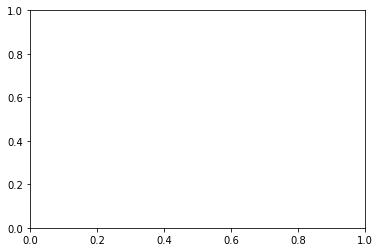

In [41]:
plt.hist(adata.X.sum(axis=1))

In [36]:
sparse.save_npz(r'..\data\filt_data.npz', filt)

In [34]:
filt = adata[:, adata.X.sum(axis=0) > 100].X
filt = sparse.csr_matrix(filt, dtype='int64')

# np.savez(fname=r'..\data\filt_counts.csv', X=filt)

# sparse.save_npz(r'..\data\filt_data.npz', filt, )

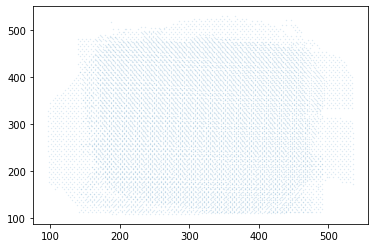

In [30]:
plt.scatter(adata.obs.imagecol, adata.obs.imagerow, alpha=0.2, s=0.1)

In [32]:
adata.var.gene_source.unique()

array(['havana', 'ensembl_havana', 'ensembl', 'insdc'], dtype=object)

In [33]:
adata.var

,source,type,gene_id,gene_version,gene_name,gene_source,gene_biotype,gene_search,is_top_hvg
ENSG00000243485,havana,gene,ENSG00000243485,5,MIR1302-2HG,havana,lincRNA,MIR1302-2HG; ENSG00000243485,False
ENSG00000238009,ensembl_havana,gene,ENSG00000238009,6,AL627309.1,ensembl_havana,lincRNA,AL627309.1; ENSG00000238009,False
ENSG00000229905,havana,gene,ENSG00000229905,1,AL669831.2,havana,antisense,AL669831.2; ENSG00000229905,False
ENSG00000237491,havana,gene,ENSG00000237491,8,AL669831.5,havana,lincRNA,AL669831.5; ENSG00000237491,False
ENSG00000177757,havana,gene,ENSG00000177757,2,FAM87B,havana,lincRNA,FAM87B; ENSG00000177757,False
...,...,...,...,...,...,...,...,...,...
ENSG00000278817,ensembl,gene,ENSG00000278817,1,AC007325.4,ensembl,protein_coding,AC007325.4; ENSG00000278817,False
ENSG00000277196,ensembl,gene,ENSG00000277196,4,AC007325.2,ensembl,protein_coding,AC007325.2; ENSG00000277196,False
ENSG00000278384,ensembl,gene,ENSG00000278384,1,AL354822.1,ensembl,protein_coding,AL354822.1; ENSG00000278384,False
ENSG00000271254,ensembl,gene,ENSG00000271254,6,AC240274.1,ensembl,protein_coding,AC240274.1; ENSG00000271254,False


## `sc.pp` is the PreProcessing module
1. Filter highly variable genes
2. Batch-effect correction
3. per-cell normalization 
4. calculate QC metrics `pp.calculate_qc_metrics`

In [ ]:
adata

In [ ]:
sc.pp.

In [57]:
um = sc.tl.umap(adata)
um

ValueError: Did not find .uns["neighbors"]. Run `sc.pp.neighbors` first.

In [7]:
# data = pd.concat(dfs, axis=1)
data = df
data

,,AAACAACGAATAG,AAACAAGTATCTC,AAACAATCTACTA,AAACACCAATAAC,AAACAGAGCGACT,AAACAGCTTTCAG,AAACAGGGTCTAT,AAACAGTGTTCCT,AAACATGGTGAGA,AAACATTTCCCGG,...,TTGTTAGCAAATT,TTGTTCAGTGTGC,TTGTTCTAGATAC,TTGTTGGCAATGA,TTGTTGTGTGTCA,TTGTTTCACATCC,TTGTTTCATTAGT,TTGTTTCCATACA,TTGTTTGTATTAC,TTGTTTGTGTAAA
,,151507,151507,151507,151507,151507,151507,151507,151507,151507,151507,...,151507,151507,151507,151507,151507,151507,151507,151507,151507,151507
MIR1302-2HG,ENSG000002434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A,ENSG000002376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5,ENSG000001860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.1,ENSG000002380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.3,ENSG000002399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC233755.2,ENSG000002778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC233755.1,ENSG000002750,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC240274.1,ENSG000002712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# The full 12 samples of data is far too large to easily work with
## Use only 1 sample for starters

<AxesSubplot:>

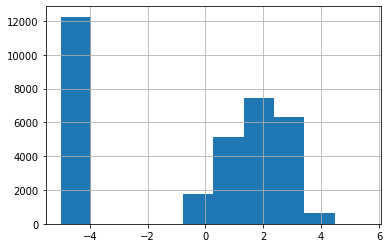

In [8]:
np.log10(data.sum(axis=1) + 0.00001).hist()

<AxesSubplot:>

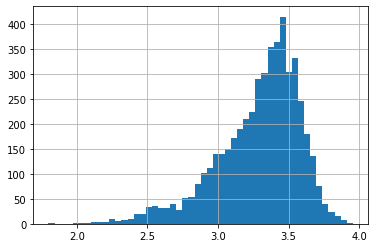

In [9]:
np.log10(data.sum(axis=0)).hist(bins=50)

In [18]:
data = data.loc[(data.sum(axis=1) > 0)]
data

,,AAACAACGAATAG,AAACAAGTATCTC,AAACAATCTACTA,AAACACCAATAAC,AAACAGAGCGACT,AAACAGCTTTCAG,AAACAGGGTCTAT,AAACAGTGTTCCT,AAACATGGTGAGA,AAACATTTCCCGG,...,TTGTTAGCAAATT,TTGTTCAGTGTGC,TTGTTCTAGATAC,TTGTTGGCAATGA,TTGTTGTGTGTCA,TTGTTTCACATCC,TTGTTTCATTAGT,TTGTTTCCATACA,TTGTTTGTATTAC,TTGTTTGTGTAAA
,,151507,151507,151507,151507,151507,151507,151507,151507,151507,151507,...,151507,151507,151507,151507,151507,151507,151507,151507,151507,151507
MIR1302-2HG,ENSG000002434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.1,ENSG000002380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL669831.5,ENSG000002374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM87B,ENSG000001777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LINC00115,ENSG000002258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,ENSG000002737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC007325.4,ENSG000002788,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
AC007325.2,ENSG000002771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

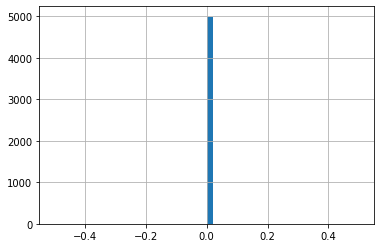

In [20]:
data.median().hist(bins=50)

In [43]:
data.loc[:, data.columns.get_level_values(1) == '1']

,,AAACAACGAATAG,AAACAAGTATCTC,AAACAATCTACTA,AAACACCAATAAC,AAACAGAGCGACT,AAACAGCTTTCAG,AAACAGGGTCTAT,AAACAGTGTTCCT,AAACATGGTGAGA,AAACATTTCCCGG,...,TTGTTAGCAAATT,TTGTTCAGTGTGC,TTGTTCTAGATAC,TTGTTGGCAATGA,TTGTTGTGTGTCA,TTGTTTCACATCC,TTGTTTCATTAGT,TTGTTTCCATACA,TTGTTTGTATTAC,TTGTTTGTGTAAA
,,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
,,151507,151507,151507,151507,151507,151507,151507,151507,151507,151507,...,151676,151676,151676,151676,151676,151676,151676,151676,151676,151676
MIR1302-2HG,ENSG000002434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A,ENSG000002376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5,ENSG000001860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.1,ENSG000002380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.3,ENSG000002399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC233755.2,ENSG000002778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC233755.1,ENSG000002750,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
num_filtered = 0
for df in dfs:
    num_filtered += df.loc[:, df.columns.get_level_values(1) == 1].shape[1]
num_filtered

47681

In [4]:
data = pd.concat(dfs, axis=1).astype(pd.SparseDtype("int16", 0))

In [57]:
# filter out all the same columns that they 

data = data.filter(regex='_1_')  

In [60]:
coldata = pd.read_csv(r'../data/column_metadata.csv', index_col=0)
rowdata = pd.read_csv('../data/row_metadata.csv', index_col=0)

data.index = rowdata.index
data.columns = coldata.index

In [72]:
data.filter(regex='-1.9$')

,AAACAAGTATCTCCCA-1.9,AAACACCAATAACTGC-1.9,AAACAGGGTCTATATT-1.9,AAACATTTCCCGGATT-1.9,AAACCCGAACGAAATC-1.9,AAACCGGGTAGGTACC-1.9,AAACCGTTCGTCCAGG-1.9,AAACCTAAGCAGCCGG-1.9,AAACCTCATGAAGTTG-1.9,AAACGAGACGGTTGAT-1.9,...,TGTCGTTATCACATAT-1.9,TGTGTAGTAGCACGTG-1.9,TTAAGGATACGGAGGT-1.9,TTAATGCGAGGTAACT-1.9,TTACTGTCTAGAGCTC-1.9,TTATAGATGCACATTA-1.9,TTCCCGACGCTTCACT-1.9,TTCTTCCCTTTGATAT-1.9,TTGAAGGATGGGCGCC-1.9,TTGCGGCGACTCATGC-1.9
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000186092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000238009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000239945,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000277856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000275063,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000271254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000277475,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# data.index = data.index.map('_'.join)
# data.columns = data.columns.map('_'.join)

In [28]:
f507 = data.filter(regex='_1_151507')


MIR1302-2HG_ENSG000002434    1
FAM138A_ENSG000002376        0
OR4F5_ENSG000001860          0
AL627309.1_ENSG000002380     6
AL627309.3_ENSG000002399     0
                            ..
AC233755.2_ENSG000002778     0
AC233755.1_ENSG000002750     0
AC240274.1_ENSG000002712     6
AC213203.1_ENSG000002774     0
FAM231C_ENSG000002686        0
Length: 33538, dtype: int64

In [40]:
np.e**4

54.59815003314423

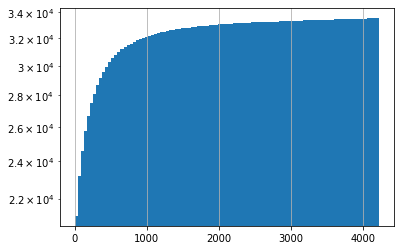

In [43]:
f507.astype('bool').sum(axis=1).hist(bins=100)
plt.yscale('log', base=10)

In [34]:
f507.loc[f507.astype('bool').sum(axis=1) < 100]

,AAACAACGAATAG_1_151507,AAACAAGTATCTC_1_151507,AAACAATCTACTA_1_151507,AAACACCAATAAC_1_151507,AAACAGCTTTCAG_1_151507,AAACAGGGTCTAT_1_151507,AAACAGTGTTCCT_1_151507,AAACATTTCCCGG_1_151507,AAACCACTACACA_1_151507,AAACCCGAACGAA_1_151507,...,TTGTGTATGCCAC_1_151507,TTGTGTTTCCCGA_1_151507,TTGTTAGCAAATT_1_151507,TTGTTCAGTGTGC_1_151507,TTGTTCTAGATAC_1_151507,TTGTTGTGTGTCA_1_151507,TTGTTTCACATCC_1_151507,TTGTTTCATTAGT_1_151507,TTGTTTCCATACA_1_151507,TTGTTTGTGTAAA_1_151507
MIR1302-2HG_ENSG000002434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A_ENSG000002376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5_ENSG000001860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.1_ENSG000002380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.3_ENSG000002399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC233755.2_ENSG000002778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC233755.1_ENSG000002750,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC240274.1_ENSG000002712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC213203.1_ENSG000002774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,AAACAACGAATAG_1_151507,AAACAAGTATCTC_1_151507,AAACAATCTACTA_1_151507,AAACACCAATAAC_1_151507,AAACAGAGCGACT_0_151507,AAACAGCTTTCAG_1_151507,AAACAGGGTCTAT_1_151507,AAACAGTGTTCCT_1_151507,AAACATGGTGAGA_0_151507,AAACATTTCCCGG_1_151507,...,TTGTTAGCAAATT_1_151676,TTGTTCAGTGTGC_1_151676,TTGTTCTAGATAC_0_151676,TTGTTGGCAATGA_0_151676,TTGTTGTGTGTCA_1_151676,TTGTTTCACATCC_1_151676,TTGTTTCATTAGT_1_151676,TTGTTTCCATACA_1_151676,TTGTTTGTATTAC_0_151676,TTGTTTGTGTAAA_1_151676
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000186092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000238009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000239945,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000277856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000275063,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000271254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000277475,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
data

,AAACAACGAATAG_1_151507,AAACAAGTATCTC_1_151507,AAACAATCTACTA_1_151507,AAACACCAATAAC_1_151507,AAACAGAGCGACT_0_151507,AAACAGCTTTCAG_1_151507,AAACAGGGTCTAT_1_151507,AAACAGTGTTCCT_1_151507,AAACATGGTGAGA_0_151507,AAACATTTCCCGG_1_151507,...,TTGTTAGCAAATT_1_151676,TTGTTCAGTGTGC_1_151676,TTGTTCTAGATAC_0_151676,TTGTTGGCAATGA_0_151676,TTGTTGTGTGTCA_1_151676,TTGTTTCACATCC_1_151676,TTGTTTCATTAGT_1_151676,TTGTTTCCATACA_1_151676,TTGTTTGTATTAC_0_151676,TTGTTTGTGTAAA_1_151676
"(havana, gene, ENSG00000243485, 5, MIR1302-2HG, havana, lincRNA, MIR1302-2HG; ENSG00000243485, False)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(havana, gene, ENSG00000237613, 2, FAM138A, havana, lincRNA, FAM138A; ENSG00000237613, False)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(ensembl_havana, gene, ENSG00000186092, 6, OR4F5, ensembl_havana, protein_coding, OR4F5; ENSG00000186092, False)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(ensembl_havana, gene, ENSG00000238009, 6, AL627309.1, ensembl_havana, lincRNA, AL627309.1; ENSG00000238009, False)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(havana, gene, ENSG00000239945, 1, AL627309.3, havana, lincRNA, AL627309.3; ENSG00000239945, False)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(ensembl, gene, ENSG00000277856, 1, AC233755.2, ensembl, protein_coding, AC233755.2; ENSG00000277856, False)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(ensembl, gene, ENSG00000275063, 1, AC233755.1, ensembl, protein_coding, AC233755.1; ENSG00000275063, False)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(ensembl, gene, ENSG00000271254, 6, AC240274.1, ensembl, protein_coding, AC240274.1; ENSG00000271254, False)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(ensembl, gene, ENSG00000277475, 1, AC213203.1, ensembl, protein_coding, AC213203.1; ENSG00000277475, False)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
rowdata

,source,type,gene_id,gene_version,gene_name,gene_source,gene_biotype,gene_search,is_top_hvg
ENSG00000243485,havana,gene,ENSG00000243485,5,MIR1302-2HG,havana,lincRNA,MIR1302-2HG; ENSG00000243485,False
ENSG00000237613,havana,gene,ENSG00000237613,2,FAM138A,havana,lincRNA,FAM138A; ENSG00000237613,False
ENSG00000186092,ensembl_havana,gene,ENSG00000186092,6,OR4F5,ensembl_havana,protein_coding,OR4F5; ENSG00000186092,False
ENSG00000238009,ensembl_havana,gene,ENSG00000238009,6,AL627309.1,ensembl_havana,lincRNA,AL627309.1; ENSG00000238009,False
ENSG00000239945,havana,gene,ENSG00000239945,1,AL627309.3,havana,lincRNA,AL627309.3; ENSG00000239945,False
...,...,...,...,...,...,...,...,...,...
ENSG00000277856,ensembl,gene,ENSG00000277856,1,AC233755.2,ensembl,protein_coding,AC233755.2; ENSG00000277856,False
ENSG00000275063,ensembl,gene,ENSG00000275063,1,AC233755.1,ensembl,protein_coding,AC233755.1; ENSG00000275063,False
ENSG00000271254,ensembl,gene,ENSG00000271254,6,AC240274.1,ensembl,protein_coding,AC240274.1; ENSG00000271254,False
ENSG00000277475,ensembl,gene,ENSG00000277475,1,AC213203.1,ensembl,protein_coding,AC213203.1; ENSG00000277475,False


In [31]:
# pd.to_hdf  fails on sparse data

# data.to_hdf('test_dense_table.h5', 'test', mode='w', format='table', 
# #             complib='blosc',
# #             complevel=9
#            )
# store = pd.HDFStore('store.h5')

# store['data'] = data  # save it
# store['data']  # load it

In [23]:
# to_csv only wrote 400 MB out of ~16 GB in 5 minutes on a non-sparse dataframe
# data.to_csv(r'..\data\raw_data.csv')

In [18]:
# parquet fails on sparse data type
# data.to_parquet('parquet_test')

In [21]:
data.to_pickle(r'..\data\pickle_test.pkl')

In [46]:
2**8

256

In [44]:
dff = pd.DataFrame(np.full(fill_value=1000, shape=(10000, 4)))

dff.iloc[:9998] = 0

sdf = dff.astype(pd.SparseDtype("int16", 0))
sdf

,0,1,2,3
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
9995,0,0,0,0
9996,0,0,0,0
9997,0,0,0,0
9998,1000,1000,1000,1000


In [35]:
dff

,0,1,2,3
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
9995,0,0,0,0
9996,0,0,0,0
9997,0,0,0,0
9998,1,1,1,1
